In [219]:
import os
import sys

# Get the current working directory
current_dir = os.getcwd()
# Add the ./src folder to the Python module search path
sys.path.append(os.path.join(current_dir, '..', 'src'))

from utils import *

import numpy as np
import pandas as pd
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt
import pickle as pkl
import os
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, KFold, RandomizedSearchCV
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder

import xgboost as xgb


sns.set_style('ticks')

In [179]:
input_path = '../Data'

feature_file = 'deepnose_features.npy'
CID_file = 'molecules_train_cid.npy'

mixture_file = 'Mixure_Definitions_Training_set.csv'
intensity_file = 'Mixure_Definitions_Intensity_Training_set.csv'
training_task_file = 'TrainingData_mixturedist.csv'

features = np.load(os.path.join(input_path, feature_file))
training_set = pd.read_csv(os.path.join(input_path, training_task_file))
mixtures_IDs = pd.read_csv(os.path.join(input_path, mixture_file))
molecule_intensities = pd.read_csv(os.path.join(input_path, intensity_file))

features_CIDs = np.load(os.path.join(input_path, CID_file))

In [180]:
extended_features = np.load(os.path.join(input_path, 'Extra/deepnose_features_extRavia.npy'))
extended_training_set = pd.read_csv(os.path.join(input_path, 'Extra/extended_training_set.csv'))
extended_mixture_IDs = pd.read_csv(os.path.join(input_path, 'Extra/extended_mixture_IDs.csv'))
extended_molecule_intensities = pd.read_csv(os.path.join(input_path, 'Extra/extended_molecule_intensites.csv'))
extended_features_CIDs = np.load(os.path.join(input_path, 'Extra/extended_ravia_cid.npy'))

In [181]:
extended_mixture_IDs

,Dataset,Mixture Label,CID,CID.0,CID.1,CID.2,CID.3,CID.4,CID.5,CID.6,...,CID.8,CID.9,CID.10,CID.11,CID.12,CID.13,CID.14,CID.15,CID.16,CID.17
0,Exp1,1,326,26331,1140,11002,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Exp1,2,7410,240,93009,8635,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Exp1,3,6544,62433,7519,7685,3314,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Exp1,4,31276,8148,7762,18827,7714,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Exp1,5,7519,8148,31252,8103,7710,11002,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
103,Exp6,294,7406,7749,8130,8174,8797,10882,10890,22201,...,82229,93375,5281167,0,0,0,0,0,0,0
104,Exp6,295,263,2758,6106,6544,7519,8129,18458,26331,...,82227,82229,5323652,0,0,0,0,0,0,0
105,Exp6,296,326,999,6305,6544,7406,11002,12265,439570,...,0,0,0,0,0,0,0,0,0,0
106,Exp6,297,660,1213,6544,8129,22201,26331,82227,82229,...,0,0,0,0,0,0,0,0,0,0


In [182]:
scaler = StandardScaler(with_mean=True, with_std=True)
epsilon = 1e-8
features = scaler.fit_transform(np.log(features + epsilon))
CID2features =  {CID: features[i] for i, CID in enumerate(features_CIDs)}

In [183]:
extended_features = scaler.fit_transform(np.log(extended_features + epsilon))
extended_CID2features =  {CID: extended_features[i] for i, CID in enumerate(extended_features_CIDs)}

In [184]:
# overlapped_CIDs = list(set(extended_features_CIDs) & set(features_CIDs))
# overlapped_CIDs[2]
# extended_CID2features[7685]
# CID2features[7685]

In [185]:
for key, value in extended_CID2features.items():
        if key not in CID2features:
            CID2features[key] = value

#### Prepare for `X_features` and `y_true`

In [186]:
# Define the scaling constant
scaling_constant = 2 # Adjust this value as needed

# Get the list of column names containing "CID"
cid_columns = [col for col in molecule_intensities.columns if 'CID' in col]

# Create a mask to identify rows where "Dataset" is in ['Snitz 1', 'Snitz 2', 'Bushdid']
mask = molecule_intensities['Dataset'].isin(['Snitz 1', 'Snitz 2', 'Bushdid'])

# Scale the values of "CID" columns for the selected rows
molecule_intensities.loc[mask, cid_columns] *= scaling_constant

In [187]:
X = []
y = []
num_monos = []
CIDs_all = []

for _, row in training_set.iterrows():
    mixture1 = combine_molecules_intensity_weighed(label=row['Mixture 1'], dataset=row['Dataset'],
                                            mixtures_IDs=mixtures_IDs, CID2features=CID2features,
                                            mixtures_intensities= molecule_intensities)
    mixture2 = combine_molecules_intensity_weighed(label=row['Mixture 2'], dataset=row['Dataset'],
                                            mixtures_IDs=mixtures_IDs, CID2features=CID2features,
                                            mixtures_intensities= molecule_intensities)
    X.append((mixture1, mixture2))
    y.append(row['Experimental Values'])

In [188]:
_, _, num_mixtures, all_pairs_CIDs = format_Xy(training_set,  mixtures_IDs, CID2features, method = 'avg')

- each `x` in `X` contains a two vector tuple `(mixture_1, mixture_2)`, index ordered same way as `training_set`
- `method` specifies the ways to create the mixture embeeding from 

In [189]:
# Convert the input pairs to a suitable format for training
X_pairs = np.array([(np.concatenate((x1, x2))) for x1, x2 in X])
y_true = np.array(y)

In [190]:
distances = [get_euclidean_distance(m[0], m[1]) for m in X]
similarities = [get_cosine_similarity(m[0], m[1]) for m in X]
angles = [get_cosine_angle(m[0], m[1]) for m in X]

In [191]:
shared_monos = [ len( set(pair[0]).intersection(set(pair[1]))) for pair in all_pairs_CIDs]
diff_monos = [ len( set(pair[0]).difference(set(pair[1]))) for pair in all_pairs_CIDs]

In [192]:
datasets = training_set['Dataset'].to_numpy()
encoder = OneHotEncoder()
data_arr = encoder.fit_transform(datasets.reshape(-1, 1))
data_arr = data_arr.toarray()

In [193]:
### add all information above
X_features = np.hstack((X_pairs, np.array(distances).reshape(500, 1), 
                        np.array(similarities).reshape(500, 1), 
                        np.array(angles).reshape(500, 1), 
                        np.array(shared_monos).reshape(500, 1), 
                        np.array(diff_monos).reshape(500, 1), 
                        np.array(num_mixtures), 
                        data_arr,
                        np.zeros((500, 1)) # this is given the addition of the new dataset// changed to 2 after filtiering out exp1
                        ))

In [194]:
training_set['Eucledian Dist'] = distances
training_set['Cosyne Sim'] = similarities
training_set['Angle'] = angles
training_set['Sum num monos'] = np.array(num_mixtures).sum(axis = 1)
training_set['Shared'] = shared_monos
training_set['Diff'] = diff_monos
training_set['Num mixture1'] = np.array(num_mixtures)[:, 0]
training_set['Num mixture2'] = np.array(num_mixtures)[:, 1]

In [195]:
training_set

,Dataset,Mixture 1,Mixture 2,Experimental Values,Eucledian Dist,Cosyne Sim,Angle,Sum num monos,Shared,Diff,Num mixture1,Num mixture2
0,Snitz 1,1,2,0.604167,0.000005,0.504608,1.041869,20,0,10,10,10
1,Snitz 1,1,3,0.651042,0.000005,-0.000072,1.570869,11,0,10,10,1
2,Snitz 1,1,5,0.505208,0.000008,0.205765,1.363551,40,0,10,10,30
3,Snitz 1,1,6,0.411458,0.000011,0.152199,1.418004,50,0,10,10,40
4,Snitz 1,1,7,0.562500,0.000005,0.270810,1.296562,14,0,10,10,4
...,...,...,...,...,...,...,...,...,...,...,...,...
495,Bushdid,509,510,0.461538,0.000005,0.784591,0.668759,60,20,10,30,30
496,Bushdid,513,514,0.692308,0.000007,0.106212,1.464384,40,0,20,20,20
497,Bushdid,515,516,0.730769,0.000005,0.341924,1.221833,20,3,7,10,10
498,Bushdid,517,518,0.538462,0.000010,-0.316481,1.892814,40,0,20,20,20


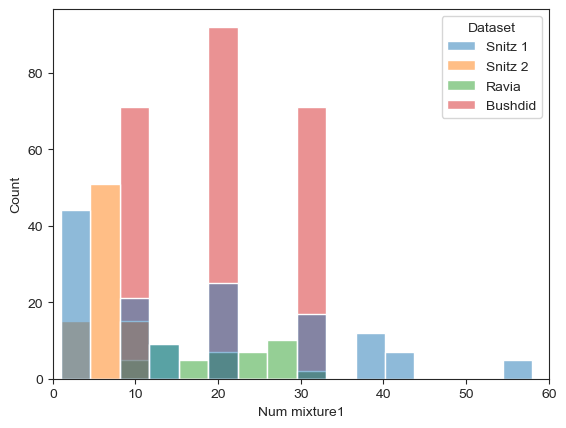

In [196]:
sns.histplot(training_set, x = 'Num mixture1', hue = 'Dataset')
plt.xlim([0, 60])
plt.show()

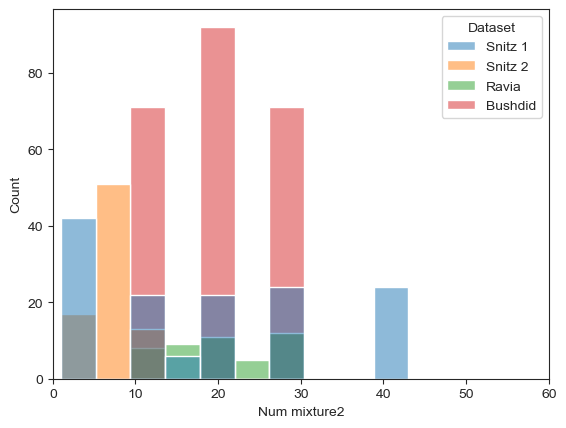

In [197]:
sns.histplot(training_set, x = 'Num mixture2', hue = 'Dataset')
plt.xlim([0, 60])
plt.show()

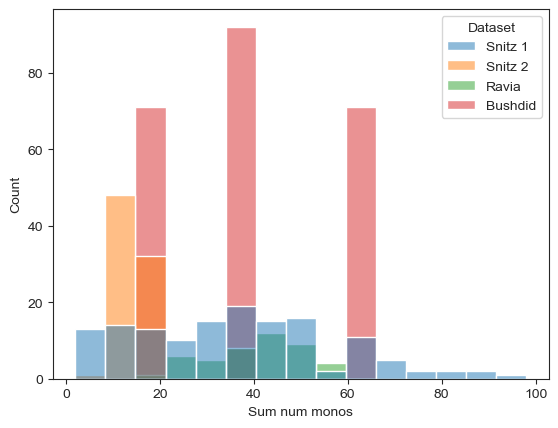

In [198]:
sns.histplot(training_set, x = 'Sum num monos', hue = 'Dataset')
plt.show()

#### Prepare `X_features_aug` and `y_true_aug`:

In [199]:
extended_training_set['Dataset'].unique()

array(['Exp1', 'Exp2', 'Exp6'], dtype=object)

In [200]:
extended_training_set

,Dataset,Mixture 1,Mixture 2,Experimental Values
0,Exp1,1,3,38.477273
1,Exp1,1,8,44.840909
2,Exp1,1,11,31.022727
3,Exp1,2,5,41.000000
4,Exp1,2,7,65.181818
...,...,...,...,...
310,Exp6,294,294,78.000000
311,Exp6,295,295,68.000000
312,Exp6,296,296,76.000000
313,Exp6,297,297,70.588234


In [201]:
extended_training_set = extended_training_set[extended_training_set['Dataset']!= 'Exp1']

In [202]:
print(f'total extended data to use: {len(extended_training_set)}')

total extended data to use: 220


In [203]:
def combine_molecules_intensity_weighed_local(label, dataset, mixtures_IDs, CID2features, intensity_IDs):
    # Grab the unique data row:
    row = mixtures_IDs[(mixtures_IDs['Mixture Label'] == label) & (mixtures_IDs['Dataset'] == dataset)]
    intesnity_row = intensity_IDs[(intensity_IDs['Mixture Label'] == label) & (intensity_IDs['Dataset'] == dataset)]

    non_zero_CIDs = row.loc[:, row.columns.str.contains('CID')].loc[:, (row != 0).any(axis=0)]
    non_zero_intensities = intesnity_row.loc[:, intesnity_row.columns.str.contains('CID')].loc[:, (intesnity_row != 0).any(axis=0)]
    if len(non_zero_CIDs) != 1:
        print('Not a Unique pointer!!!')
    CIDs = non_zero_CIDs.iloc[0].tolist()
    intensities = non_zero_intensities.iloc[0].tolist()
    CID2intensity = dict(zip(CIDs, intensities))

    molecule_embeddings = []
    # Create feature matrix for all number of mono odor molecules in the mixture:
    for CID in CIDs:
        molecule_embeddings.append(np.array(CID2features[CID])*intensity_function(CID2intensity[CID]))

    mixture_embedding = np.nansum(molecule_embeddings, axis=0)
    return CIDs, mixture_embedding


In [204]:
X_extended = []
y_extended = []
num_monos = []
CIDs_all = []
count = 0
extended_training_set_used = extended_training_set.copy()  # Create a copy of the original DataFrame

for _, row in extended_training_set.iterrows():
    CID1, mixture1 = combine_molecules_intensity_weighed_local(label=row['Mixture 1'], dataset=row['Dataset'],
                                            mixtures_IDs=extended_mixture_IDs, CID2features=CID2features,
                                            intensity_IDs= extended_molecule_intensities)
    CID2, mixture2 = combine_molecules_intensity_weighed_local(label=row['Mixture 2'], dataset=row['Dataset'],
                                            mixtures_IDs=extended_mixture_IDs, CID2features=CID2features,
                                            intensity_IDs= extended_molecule_intensities)
    
    percent1 = np.array([elem in features_CIDs for elem in CID1]).sum()/len(CID1)
    percent2 = np.array([elem in features_CIDs for elem in CID2]).sum()/len(CID2)
    if percent1 > .5 or percent2 > .5:
        count += 1
        X_extended.append((mixture1, mixture2))
        y_extended.append(row['Experimental Values']/100)
    else:
        # Remove the row from extended_training_set_used if the condition is not met
        extended_training_set_used = extended_training_set_used.drop(row.name)



In [205]:
len_added = len(y_extended)
print(f'We will have a total of {len(y_extended)} extra Ravia samples.')

We will have a total of 55 extra Ravia samples.


In [206]:
X_extended = np.array([(np.concatenate((x1, x2))) for (x1, x2) in X_extended])

In [207]:
_, _, extra_num_mixtures, extend_pairs_CIDs = format_Xy(extended_training_set_used,  extended_mixture_IDs, CID2features, method = 'avg')

- each `x` in `X` contains a two vector tuple `(mixture_1, mixture_2)`, index ordered same way as `training_set`
- `method` specifies the ways to create the mixture embeeding from 

In [208]:
y_true_extended = np.array(y_extended)

In [209]:
distances_e = [get_euclidean_distance(m[0], m[1]) for m in X_extended]
similarities_e = [get_cosine_similarity(m[0], m[1]) for m in X_extended]
angles_e = [get_cosine_angle(m[0], m[1]) for m in X_extended]

In [210]:
shared_monos_e = [ len( set(pair[0]).intersection(set(pair[1]))) for pair in extend_pairs_CIDs]
diff_monos_e = [ len( set(pair[0]).difference(set(pair[1]))) for pair in extend_pairs_CIDs]

In [211]:
datasets_e = extended_training_set_used['Dataset'].to_numpy()
encoder = OneHotEncoder()
data_arr_e = encoder.fit_transform(datasets_e.reshape(-1, 1))
data_arr_e = data_arr_e.toarray()

In [212]:
### add all information above
X_features_extended = np.hstack((X_extended, np.array(distances_e).reshape(len_added, 1), 
                        np.array(similarities_e).reshape(len_added, 1), 
                        np.array(angles_e).reshape(len_added, 1), 
                        np.array(shared_monos_e).reshape(len_added, 1), 
                        np.array(diff_monos_e).reshape(len_added, 1), 
                        np.array(extra_num_mixtures), 
                        np.zeros((len_added, 4)), # this is given the addition of the new dataset
                        data_arr_e
                        ))

In [213]:
aug_num = 55
indices = np.random.choice(len(y_true_extended), size=aug_num, replace=False)
X_features_aug = X_features_extended[indices]
y_true_aug = np.array(y_true_extended)[indices]

In [214]:
rf_best =  {'n_estimators': 250, 'min_samples_split': 2, 'max_features': 'sqrt', 'max_depth': 30, 'bootstrap': True}
xgb_best = {'subsample': 0.7, 'n_estimators': 250, 'max_depth': 9, 'learning_rate': 0.01, 'colsample_bytree': 0.7}

In [215]:
X_features.shape

(500, 204)

In [216]:
X_features_aug.shape

(55, 204)

In [217]:
seed = 314159
n_folds = 10

rf_pred_list = []
xgb_pred_list = []
y_true_list = []
test_indices_list = []  # Keep track of the test indices in each fold

# Stack the original X and augmented X_pool
stacked_X = np.vstack((X_features, X_features_aug))
# Stack the original y_true and augmented y_pool
stacked_y = np.concatenate((y_true, y_true_aug))

# Get the number of original samples
n_original_samples = X_features.shape[0]

# Perform k-fold cross-validation:
kf = KFold(n_splits=n_folds, shuffle=True, random_state=seed)
for train_index, test_index in kf.split(stacked_X):
    X_train, X_test = stacked_X[train_index], stacked_X[test_index]
    y_train, y_test = stacked_y[train_index], stacked_y[test_index]

    # Get the original test indices
    original_test_index = test_index[test_index < n_original_samples]
    
    # Train the Random Forest regressor
    rf = RandomForestRegressor(**rf_best, random_state=seed)
    # rf = RandomForestRegressor(n_estimators=100, random_state=seed)
    
    rf.fit(X_train, y_train)
    
    # Train the XGBoost regressor
    # xgb_model = xgb.XGBRegressor(n_estimators=100, random_state=seed)
    xgb_model = xgb.XGBRegressor(**xgb_best, random_state=seed)
    xgb_model.fit(X_train, y_train)
    
    # Make predictions on the original X_features
    rf_pred = rf.predict(stacked_X[original_test_index])
    xgb_pred = xgb_model.predict(stacked_X[original_test_index])
    
    rf_pred_list.extend(rf_pred)
    xgb_pred_list.extend(xgb_pred)
    y_true_list.extend(y_true[original_test_index])  # Use the original y_true for evaluation
    test_indices_list.extend(original_test_index)  # Store the original test indices

# Store the predictions and actual values
results_df = pd.DataFrame({
    'test_index': test_indices_list,
    'rf_pred': rf_pred_list,
    'xgb_pred': xgb_pred_list,
    'y_true': y_true_list
})

# Merge the results with the training_set df
training_set = training_set.merge(results_df, left_index=True, right_on='test_index')
training_set.drop('test_index', axis=1, inplace=True)

In [218]:
# Calculate the correlation and R^2 for Random Forest
rf_corr = np.corrcoef(rf_pred_list, y_true_list)[0, 1]
rf_rmse = np.sqrt(mean_squared_error(np.array(y_true_list), np.array(rf_pred_list)))

print(f"Random Forest - R: {rf_corr:.3f}")
print(f"Random Forest - RMSE: {rf_rmse:.3f}")
print()
# Calculate the correlation and R^2 for XGBoost
xgb_corr = np.corrcoef(xgb_pred_list, y_true_list)[0, 1]
xgb_rmse = np.sqrt(mean_squared_error(np.array(y_true_list), np.array(xgb_pred_list)))

print(f"XGBoost - R: {xgb_corr:.3f}")
print(f"XGBoost - RMSE: {xgb_rmse:.3f}")


Random Forest - R: 0.636
Random Forest - RMSE: 0.122

XGBoost - R: 0.628
XGBoost - RMSE: 0.123


In [221]:
data_dict = {'X_features': X_features, 'y_true': y_true, 'X_features_aug':X_features_aug, "y_true_aug": y_true_aug }
with open('../Data/ML_features/augmentset.pkl', 'wb') as f:
    pkl.dump(data_dict, f)